## gotoflux() function

* 09/16: add sigma clipping and plotting  
* fixed on 09/11
* see k2phot_v2 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from glob import glob
import getpass

#fitfiles = glob('new_example_input/*.fits')
#fitfiles = glob('/home/jp/data/transit/c14/*.fits.gz')

folders = glob('/home/jp/github/transit/cranky/output/*')
folders

['/home/jp/github/transit/cranky/output/figs',
 '/home/jp/github/transit/cranky/output/20159908',
 '/home/jp/github/transit/cranky/output/24866269',
 '/home/jp/github/transit/cranky/output/20145408',
 '/home/jp/github/transit/cranky/output/chain.npy.gz']

## raw

In [4]:
import pandas as pd
from astropy.stats import sigma_clip

d = glob(os.path.join(folders[2],'*raw*.txt'))[0]
df = pd.read_csv(d, skiprows=1, delimiter=' ', names=['t','f','x','y'])
df['f_clip'] = sigma_clip(df.f, sigma_upper=2,sigma_lower=10)
df['fmed'] = df.f_clip.apply(lambda x: x/np.nanmedian(df.f_clip))
df['f_mask'] = df.fmed[df.fmed.apply(lambda x: (x > 0.9) & (x < 1.1))]
df.head()

,t,f,x,y,f_clip,fmed,f_mask
0,3072.723055,3818319.0,572.403585,966.464704,3818319.0,0.990996,0.990996
1,3072.743489,3821228.0,572.406562,966.464730,3821228.0,0.991751,0.991751
2,3072.763923,3824836.0,572.409431,966.463025,3824836.0,0.992687,0.992687
3,3072.784356,3827722.0,572.413336,966.462434,3827722.0,0.993436,0.993436
4,3072.804790,3830503.0,572.419457,966.461292,3830503.0,0.994158,0.994158


39


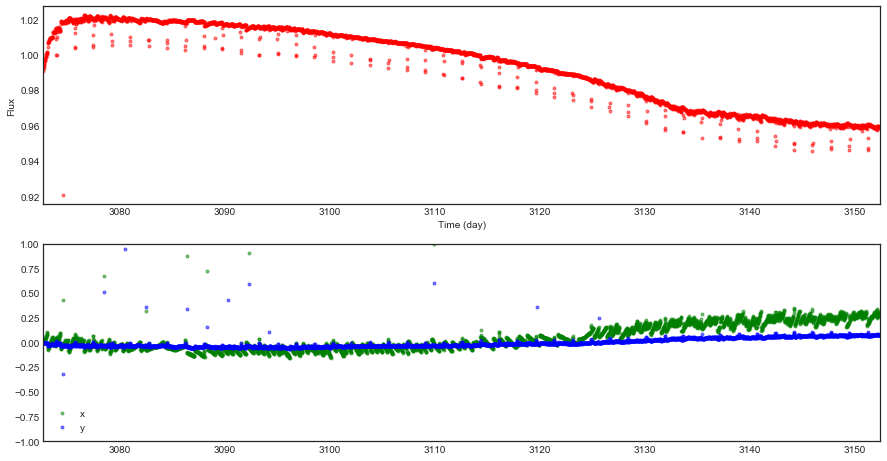

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(2,1,figsize=(15,8))
#ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax[0].plot(df.t, df.f_mask,'.', alpha=0.5, color='r', marker='.')
ax[0].set_ylabel('Flux')
ax[0].set_xlabel('Time (day)')
#ax[0].set_ylim([np.median(df.fmed)-0.1,np.median(df.fmed)+0.1])
ax[0].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
#centroid drift
ax[1].plot(df.t, df.x.apply(lambda x: x-df.x.iloc[0]),'.', alpha=0.5, color='g', marker='.', label='x')
ax[1].plot(df.t, df.y.apply(lambda x: x-df.y.iloc[0]),'.', alpha=0.5, color='b', marker='.', label='y')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
plt.legend()

print(np.isnan(df.f_mask).sum())

In [6]:
x=df.x
y=df.y
f=df.f/np.median(df.f)
t=df.t

#design matrix
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]

In [7]:
#coeff
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

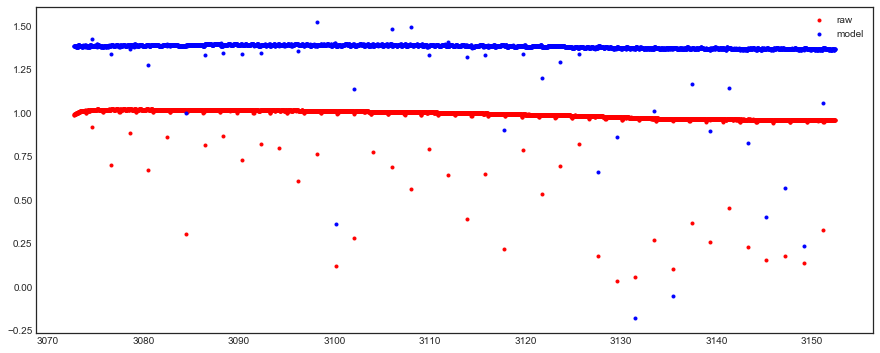

In [8]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

In [9]:
#sigma clipping
from astropy.stats import sigma_clip

fmask= sigma_clip(f, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f,x,y,t=f[~mask],x[~mask],y[~mask],t[~mask]

In [10]:
#model
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

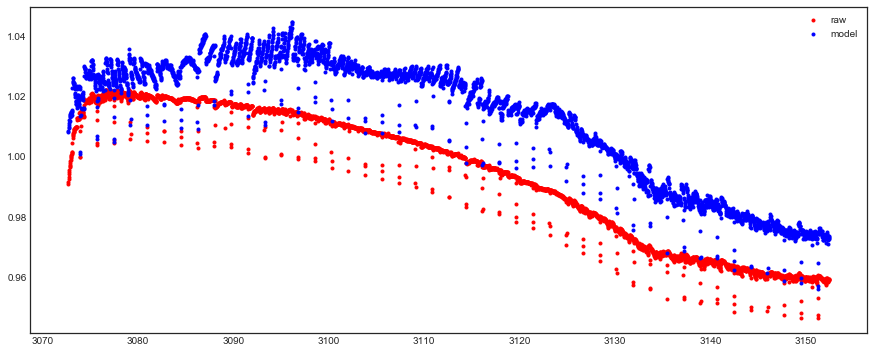

In [11]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

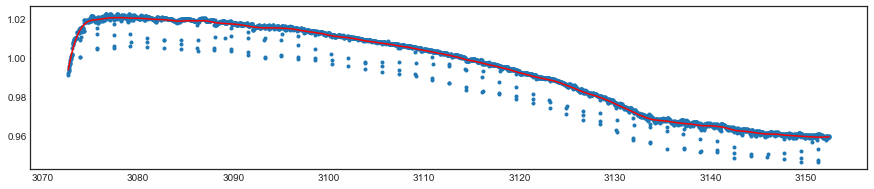

In [12]:
#fit spline

from scipy.interpolate import Rbf
rbfi = Rbf(t, f, function='quintic', smooth=100)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f, '.')
ax.plot(t, rbfi(t), 'r-')

(0.98, 1.01)

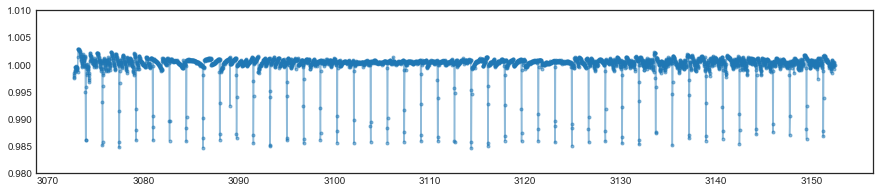

In [13]:
#detrended lc

fig, ax = pl.subplots(1,1,figsize=(15,3))

f_cd = f / rbfi(t)
pl.plot(t,f_cd,'.-', alpha=0.5 )
ax.set_ylim(0.98,1.01)

In [14]:
#sigma clipping
from astropy.stats import sigma_clip

fmask= sigma_clip(f_cd, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f_cdc,x_cdc,y_cdc,t_cdc=f_cd[~mask],x[~mask],y[~mask],t[~mask]

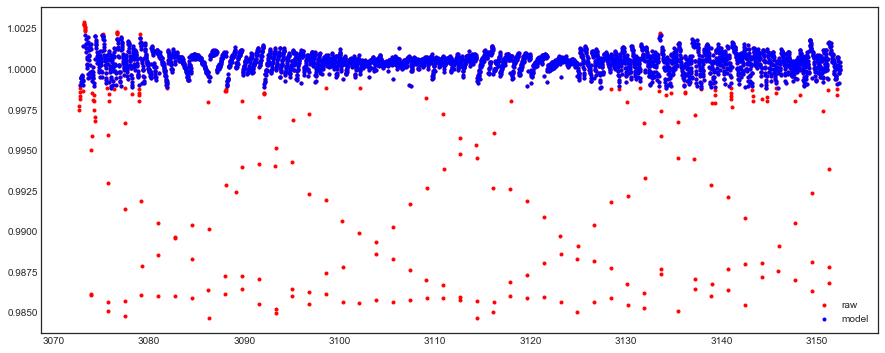

In [15]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
ax.plot(t,f_cd,'r.',label='raw')
ax.plot(t_cdc,f_cdc,'b.',label='model')
ax.legend()

In [17]:
#new model
X = np.c_[x_cdc,y_cdc,x_cdc*y_cdc,x_cdc**2,y_cdc**2,np.ones_like(x_cdc)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f_cdc)

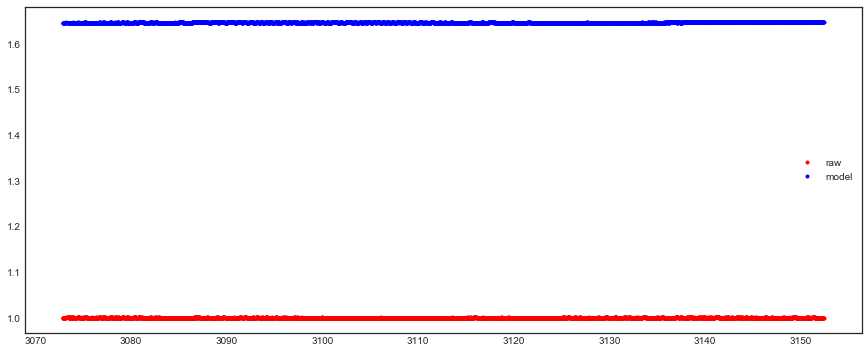

In [23]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t_cdc,f_cdc,'r.',label='raw')
ax.plot(t_cdc,f_hat,'b.',label='model')
ax.legend()

## least squares without bias

In [24]:
#new model
X = np.c_[x_cdc,y_cdc,x_cdc*y_cdc,x_cdc**2,y_cdc**2]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f_cdc)

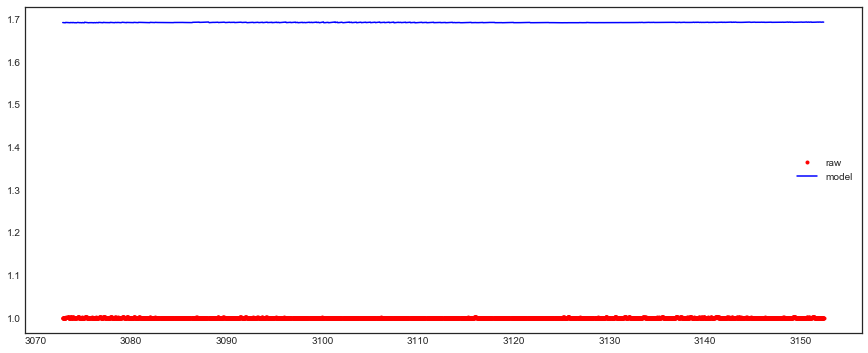

In [25]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t_cdc,f_cdc,'r.',label='raw')
ax.plot(t_cdc,f_hat,'b-',label='model')
ax.legend()

## MLE without bias, free sigma

In [101]:
from scipy import optimize as op

X = np.c_[x_cdc,y_cdc,x_cdc*y_cdc,x_cdc**2,y_cdc**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = theta[-1]
    sigma = np.exp(logsigma)
    y_model = (theta[:-1]*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0,np.log((np.std(f_cdc)))]

args = (X, f_cdc)
nll = lambda *x: -log_like(*x)

In [102]:
nll(x0, X, f_cdc)

6209167808.7451973

In [103]:
opt = op.minimize(nll, x0, args=args, method='nelder-mead')

In [104]:
print(opt.success)
print(opt.x)

True
[  2.52640025e-05   1.71691710e-04  -7.19264502e-07  -1.25577063e-06
   1.74456038e-06  -7.57699418e+00]


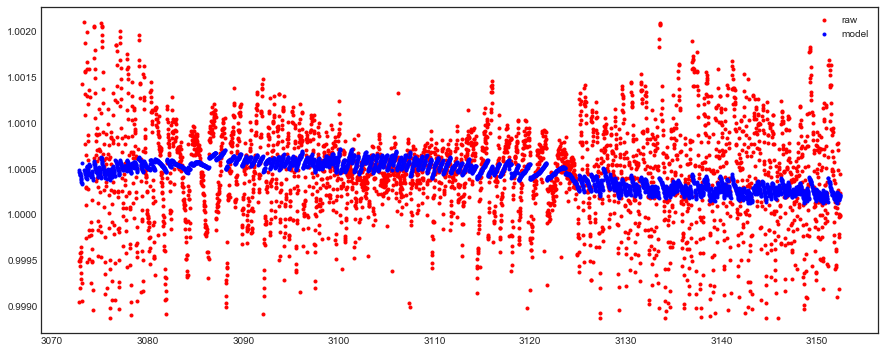

In [105]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(opt.x[:-1]*X).sum(axis=1)

ax.plot(t_cdc,f_cdc,'r.',label='raw')
ax.plot(t_cdc,f_hat,'b.',label='model')
ax.legend()

## MLE without bias, fixed sigma

In [96]:
from scipy import optimize as op

X = np.c_[x_cdc,y_cdc,x_cdc*y_cdc,x_cdc**2,y_cdc**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -1
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, f_cdc)
nll = lambda *x: -log_like(*x)

In [97]:
nll(x0, X, f_cdc)

9755.4764280922318

In [98]:
opt = op.minimize(nll, x0, args=args, method='nelder-mead')

In [99]:
print(opt.success)
print(opt.x)

True
[  8.09901812e-05   9.19961170e-05   2.32300998e-06   3.56010919e-06
  -1.69874470e-06]


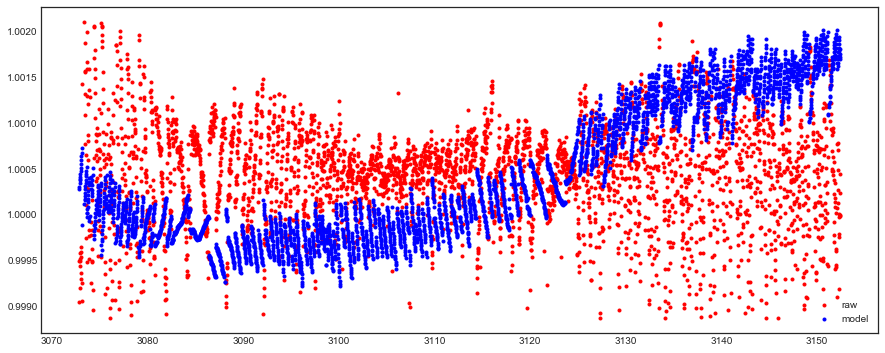

In [100]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(opt.x*X).sum(axis=1)

ax.plot(t_cdc,f_cdc,'r.',label='raw')
ax.plot(t_cdc,f_hat,'b.',label='model')
ax.legend()

Making sigma a free parameter allows the optimizer to assign small number at the expense of fitting the model. In contrast to LSE which assumes equal constant sigma, it is forced to explain all (overfit) the data.

In [34]:
#sigma
np.exp(opt.x[-1])

0.00062745482296381033

In [36]:
np.std(f_cdc)

0.00053985552390517597

## MCMC with fixed small sigma

In [37]:
from scipy import optimize as op

X = np.c_[x_cdc,y_cdc,x_cdc*y_cdc,x_cdc**2,y_cdc**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -100
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, f_cdc)
nll = lambda *x: -log_like(*x)

In [38]:
import emcee
from tqdm import tqdm

nwalkers=100
ndim = len(x0)
nsteps=1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=args)
x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in x0]
#x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in opt.x]
x0ball = np.array(x0ball).reshape(nwalkers, ndim)

In [39]:
for pos,lp,_ in tqdm(sampler.sample(x0ball,iterations=nsteps)):
    pass

1000it [01:06, 15.10it/s]


In [40]:
sampler.chain.shape

(100, 1000, 5)

In [41]:
sampler.reset
for post,lp,_ in tqdm(sampler.sample(pos,iterations=nsteps)):
    pass

1000it [01:05, 15.34it/s]


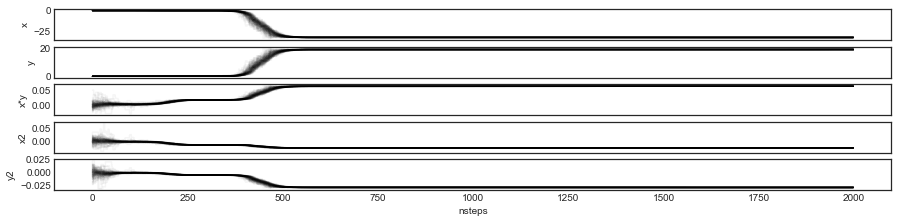

In [42]:
trace = sampler.chain
nburn=1000
labels='x,y,x*y,x2,y2'.split(',')
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(trace.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(labels)]

plt.xlabel('nsteps')

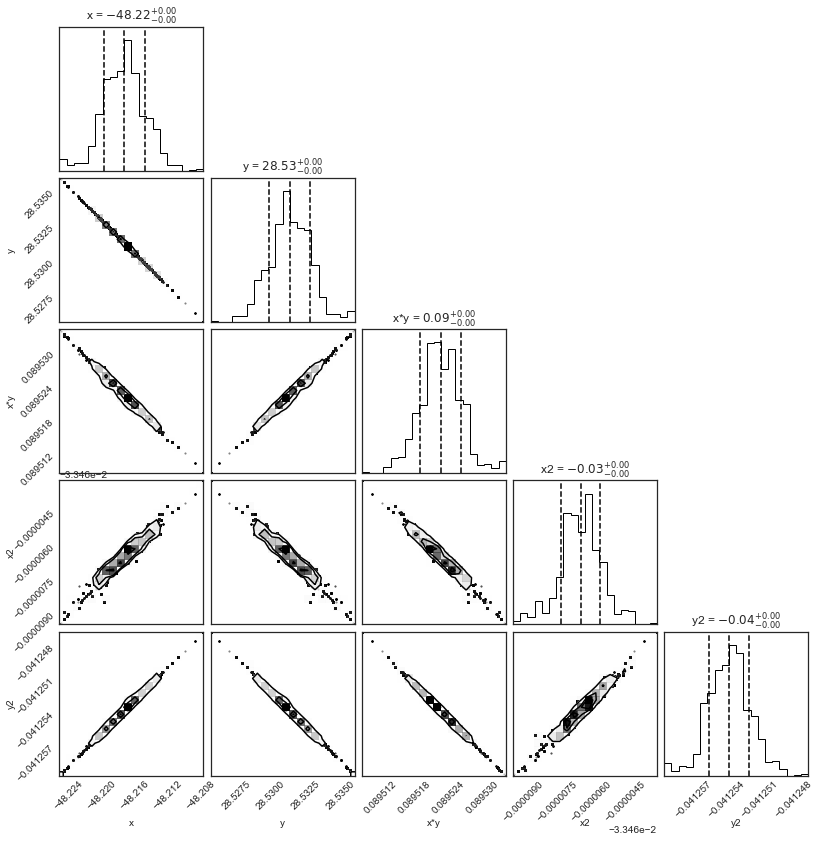

In [56]:
import corner

burn=1000
#theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]

fc=trace[:,burn:,:].reshape(nsteps*nwalkers,ndim)
corner.corner(fc, labels=labels, 
              quantiles=[0.16, 0.5, 0.84], 
              truths=beta,#theta_hat,
              show_titles=True, title_kwargs={"fontsize": 12});

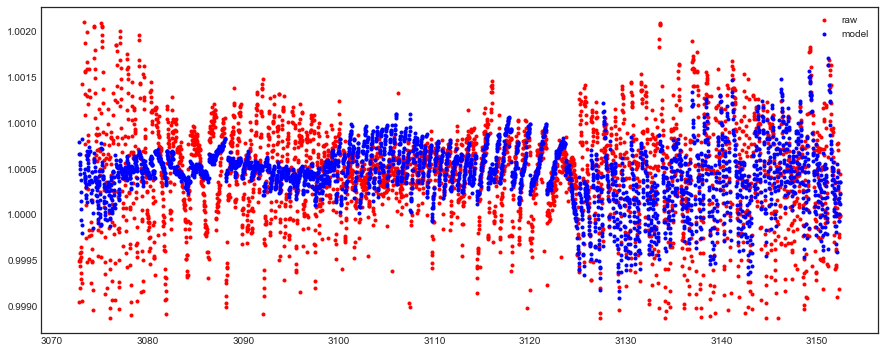

In [45]:
theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]

fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(theta_hat*X).sum(axis=1)

ax.plot(t_cdc,f_cdc,'r.',label='raw')
ax.plot(t_cdc,f_hat,'b.',label='model')
ax.legend()

## MCMC with varying sigma

In [ ]:
from scipy import optimize as op

X = np.c_[x,y,x*y,x**2,y**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = theta[-1]
    sigma = np.exp(logsigma)
    y_model = (theta[:-1]*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0,np.log((np.std(ff)))]

args = (X, ff)
nll = lambda *x: -log_like(*x)

In [ ]:
import emcee
from tqdm import tqdm

nwalkers=100
ndim = len(x0)
nsteps=1000

sampler.reset
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=args)
#x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in x0]
x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in opt.x]
x0ball = np.array(x0ball).reshape(nwalkers, ndim)

In [ ]:
for pos,lp,_ in tqdm(sampler.sample(x0ball,iterations=nsteps)):
    pass

In [ ]:
sampler.chain.shape

In [ ]:
for post,lp,_ in tqdm(sampler.sample(pos,iterations=nsteps)):
    pass

In [ ]:
trace = sampler.chain
nburn=1000
labels='x,y,x*y,x2,y2,sigma'.split(',')
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(trace.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(labels)]

plt.xlabel('nsteps')

In [ ]:
import corner

burn=1000
theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]
#f_hat=np.dot(X,beta)
fc=trace[:,burn:,:].reshape(nsteps*nwalkers,ndim)
corner.corner(fc, labels=labels, 
              quantiles=[0.16, 0.5, 0.84], 
              truths=np.concatenate((beta,[0]),axis=0),#theta_hat,
              show_titles=True, title_kwargs={"fontsize": 12});

In [ ]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(theta_hat[:-1]*X).sum(axis=1)

ax.plot(tt,ff,'r.',label='raw')
ax.plot(tt,f_hat,'b.',label='model')
ax.legend()